# Model Selection, Underfitting, and Overfitting

Explore these concepts interactively
by fitting polynomials to data

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Use the following cubic polynomial to generate the labels
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Take a look at the first 2 samples

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.4085],
         [-0.9229]]),
 tensor([[ 1.0000e+00, -1.4085e+00,  9.9199e-01, -4.6575e-01,  1.6401e-01,
          -4.6202e-02,  1.0846e-02, -2.1824e-03,  3.8426e-04, -6.0137e-05,
           8.4706e-06, -1.0846e-06,  1.2731e-07, -1.3794e-08,  1.3878e-09,
          -1.3032e-10,  1.1473e-11, -9.5056e-13,  7.4383e-14, -5.5143e-15],
         [ 1.0000e+00, -9.2286e-01,  4.2583e-01, -1.3099e-01,  3.0222e-02,
          -5.5782e-03,  8.5798e-04, -1.1311e-04,  1.3049e-05, -1.3380e-06,
           1.2348e-07, -1.0359e-08,  7.9669e-10, -5.6556e-11,  3.7281e-12,
          -2.2937e-13,  1.3230e-14, -7.1818e-16,  3.6821e-17, -1.7884e-18]]),
 tensor([-2.6435,  1.7383]))

Implement a function to evaluate the loss on a given dataset

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

Define the training function

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

Third-Order Polynomial Function Fitting (Normal)

weight: [[ 4.983265   1.2032691 -3.3766131  5.5740724]]


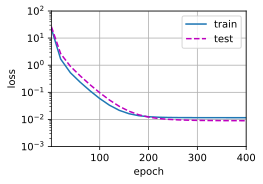

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Linear Function Fitting (Underfitting)

weight: [[3.2453077 3.93683  ]]


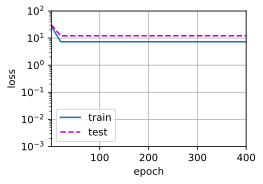

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Higher-Order Polynomial Function Fitting  (Overfitting)

weight: [[ 4.9550934   1.2626404  -3.2239823   5.2396245  -0.49092546  1.1116619
   0.19990577  0.11862182 -0.17074284  0.02433667  0.14013405 -0.1094716
   0.14219484  0.13486093  0.01366221 -0.14411381 -0.17412245 -0.20833914
   0.16658165 -0.06221166]]


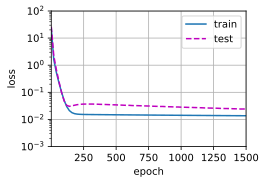

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)